Making apec models for gj676a and l-980-5 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from astropy.modeling import models, fitting



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [7]:
apath = '/media/david/1tb_storage1/emergency_data/mega_muscles/apec_odds/'

In [8]:
mods = glob.glob('{}*txt*'.format(apath))
mods

['/media/david/1tb_storage1/emergency_data/mega_muscles/apec_odds/gj676a_normed_apec.txt',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/apec_odds/l-980-5_normed_apec.txt']

In [9]:
def apec_to_spec(path):
    """
    Converts an xspec plot model wdata textfile from counts to ergs. 
    Assumes that the wavelength array is in Angstrom and the flux arrays are in counts/s/cm2/A
    """
    xrt = np.loadtxt(path, skiprows=3)
    xrt = xrt[::-1]
    wx = xrt[:,0]*u.AA
    kevx = xrt[:, 1]*u.keV
    fx  = (xrt[:,2] * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
    return wx, kevx, fx

In [10]:
wx, kevx, fx = apec_to_spec(mods[0])

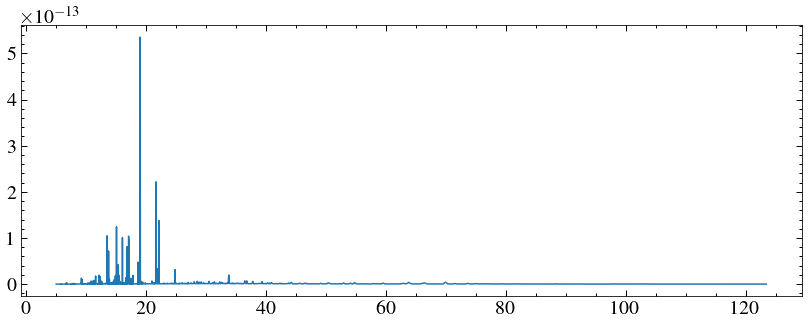

In [11]:
plt.plot(wx, fx)

In [12]:
# norm = 1.04e-4 #calcuated by trial and error so that the 0.3-10keV energy matches the Swift measurement

In [13]:
#check with the SED, make sure it makes sense
sed = fits.getdata('/media/david/1tb_storage1/emergency_data/mega_muscles/v02_seds/hlsp_muscles_multi_multi_gj676a_broadband_v2_adapt-var-res-sed.fits', 1)

In [14]:
w, f = sed['WAVELENGTH'], sed['FLUX']

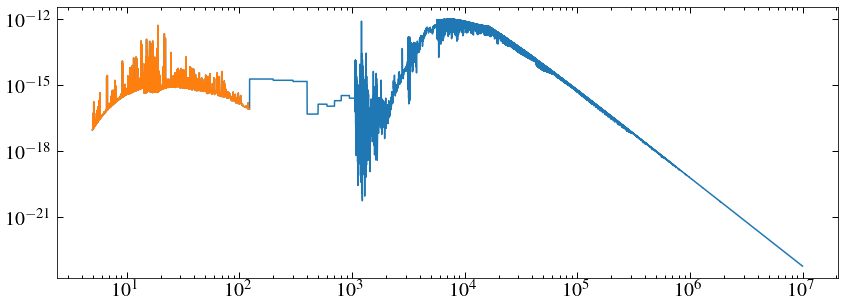

In [15]:
plt.plot(w, f)
plt.xscale('log')
plt.yscale('log')
plt.plot(wx, fx)

In [16]:
check= Table.read('1GJ1132apec.txt', format='ascii.basic')

In [17]:
wc, fc = check['WAVELENGTH'], check['FLUX']

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


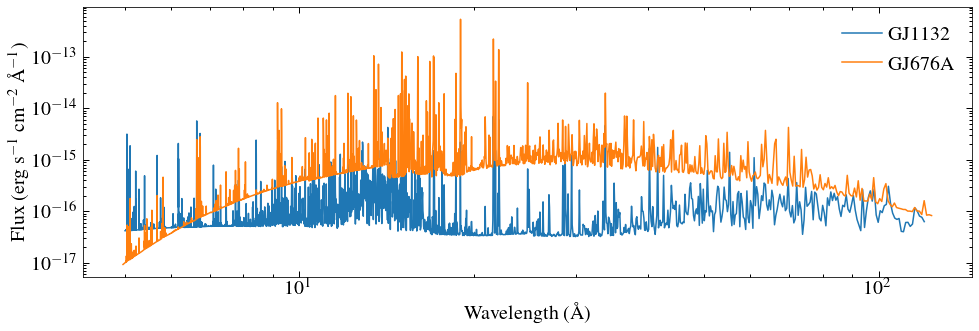

In [18]:
plt.plot(wc, fc, label ='GJ1132')
plt.yscale('log')
plt.xscale('log')
plt.plot(wx, fx, label = 'GJ676A')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/apec_test.pdf')

In [19]:
#why is the model curvy?

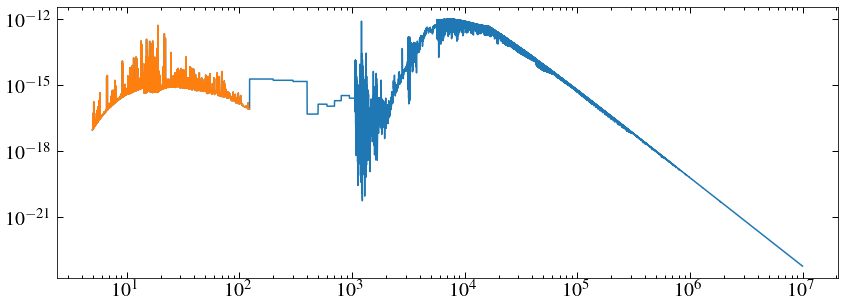

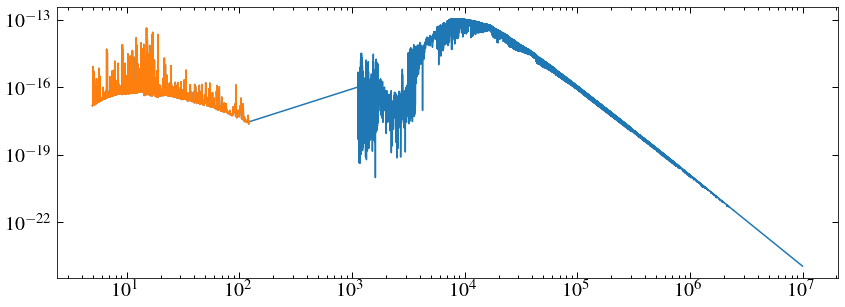

In [20]:
stars = ['gj676a', 'l-980-5']
for i, star in enumerate(stars):
    sed = fits.getdata('/media/david/1tb_storage1/emergency_data/mega_muscles/v02_seds/hlsp_muscles_multi_multi_{}_broadband_v2_adapt-var-res-sed.fits'.format(star), 1)
    w, f = sed['WAVELENGTH'], sed['FLUX']
    plt.plot(w, f)
    plt.xscale('log')
    plt.yscale('log')
    wx, kevx, fx = apec_to_spec('{}{}_normed_apec.txt'.format(apath, star))
    plt.plot(wx, fx)
    plt.show()


Ok, Christian says this all looks good. Time to turn them into MM files

In [21]:
for star in stars:
    wx, kevx, fx = apec_to_spec('{}{}_normed_apec.txt'.format(apath, star))
    savdat = Table([wx, fx], names=['WAVELENGTH', 'FLUX'])
    ascii.write(savdat, 'fake_apecs/{}apec.txt'.format(star), format='basic', overwrite=True)

In [22]:
import prepare_model

In [23]:
for star in stars:
    hlsp_path = '/media/david/1tb_storage1/emergency_data/mega_muscles/hlsp/{}/components_v1/'.format(star.upper())
    sed_table = Table.read('{}hlsp_muscles_hst_cos_{}_g130m_v1_component-spec.ecsv'.format(hlsp_path, star))
    prepare_model.make_model_spectrum('fake_apecs/{}apec.txt'.format(star), 1, sed_table ,savepath = hlsp_path, save_ecsv=True, save_fits=True, model_name='apec')

/media/david/1tb_storage1/emergency_data/mega_muscles/hlsp/GJ676A/components_v1/
Spectrum saved as hlsp_muscles_model_apec_gj676a_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_apec_gj676a_na_v1_component-spec.fits
/media/david/1tb_storage1/emergency_data/mega_muscles/hlsp/L-980-5/components_v1/
Spectrum saved as hlsp_muscles_model_apec_l-980-5_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_apec_l-980-5_na_v1_component-spec.fits


Do GJ699 DEM as I'm here. Apparently they're allready done, just need to move them to hlsp.

In [24]:
# # import prepare_euv

# dem_path = '/home/david/work/muscles/SEDs/gj_699/dem/gj699_time_average_dem.fits'
# euv_path = '/home/david/work/muscles/SEDs/gj_699/dem/'
# euv_name = 'dem'
# # prepare_euv.make_euv(euv_path, dem_path = dem_path)
# # prepare_model.make_model_spectrum(input_paths['EUV']+os.listdir(input_paths['EUV'])[0], version, sed_table ,savepath = component_repo, save_ecsv=save_components, save_fits=save_components, model_name=euv_name)

In [26]:
# def make_dem(dem_path, save_path):
#     """
#     Extracts the wavelength and flux from a DEM and saves it as a text file
#     """
#     data = fits.getdata(dem_path, 1)
#     wavelength, flux = data['Wavelength'], data['Flux_density']
#     w0, w1 = wavelength_edges(wavelength)
#     #flux = bin_flux/(w1-w0) #convert from bin-intergrated flux to flux -not required for new-generation seds
#     name = 'dem.txt' 
#     if os.path.exists(save_path) == False:
#         os.mkdir(save_path)
#     savedat = Table([wavelength, flux], names=['WAVELENGTH', 'FLUX'])
#     ascii.write(savedat, save_path+name, overwrite=True)

L-980-5 lya

In [27]:
lw, lf = np.loadtxt('lya_intermediates/L980-5_LyA_profile.txt', unpack=True)

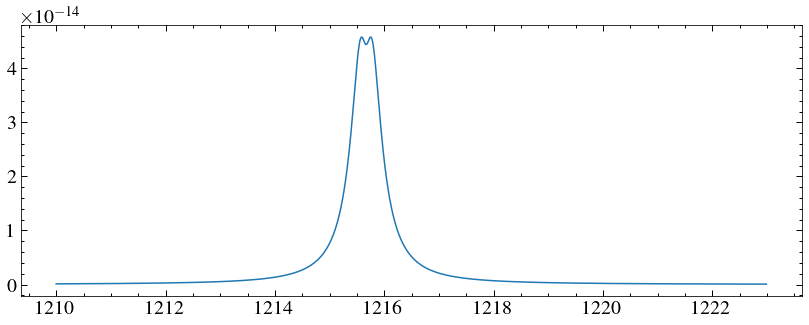

In [28]:
plt.plot(lw, lf)

In [30]:
savdat=Table([lw, lf], names=['WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'lya_intermediates/L980-5_lya_basic.txt', format='csv')

In [31]:
star = 'l-980-5'
hlsp_path = '/media/david/1tb_storage1/emergency_data/mega_muscles/hlsp/{}/components_v1/'.format(star.upper())

sed_table = Table.read('{}hlsp_muscles_hst_cos_{}_g130m_v1_component-spec.ecsv'.format(hlsp_path, star))

prepare_model.make_model_spectrum('lya_intermediates/L980-5_lya_basic.txt', 1, sed_table ,savepath = hlsp_path, save_ecsv=True, save_fits=True, normfac=1)

/media/david/1tb_storage1/emergency_data/mega_muscles/hlsp/L-980-5/components_v1/
Spectrum saved as hlsp_muscles_model_lya-reconstruction_l-980-5_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_lya-reconstruction_l-980-5_na_v1_component-spec.fits


In [60]:
import importlib
importlib.reload(prepare_euv)


# import prepare_euv
euv_path = 'euv_misc/'
dem_path = ''
euv_name = 'euv-scaling'
euv_inputs = dict(lya=4.418e-14, distance=13.4)
prepare_euv.make_euv(euv_path, dem_path, euv_inputs=euv_inputs)
prepare_model.make_model_spectrum(euv_path+os.listdir(euv_path)[0], 1, sed_table ,savepath = hlsp_path, save_ecsv=True, save_fits=True, model_name=euv_name)

/media/david/1tb_storage1/emergency_data/mega_muscles/hlsp/L-980-5/components_v1/
Spectrum saved as hlsp_muscles_model_euv-scaling_l-980-5_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_euv-scaling_l-980-5_na_v1_component-spec.fits


Something up with the euv files

In [36]:
euv = Table.read('{}hlsp_muscles_model_euv-scaling_l-980-5_na_v1_component-spec.ecsv'.format(hlsp_path))

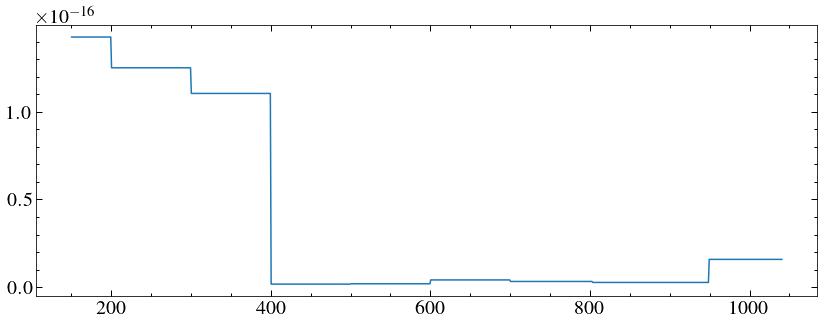

In [38]:
plt.plot(euv['WAVELENGTH'], euv['FLUX'])

9
9
1.4263487029726426e-16 1.5810462262744353e-17
100.5 1169.5


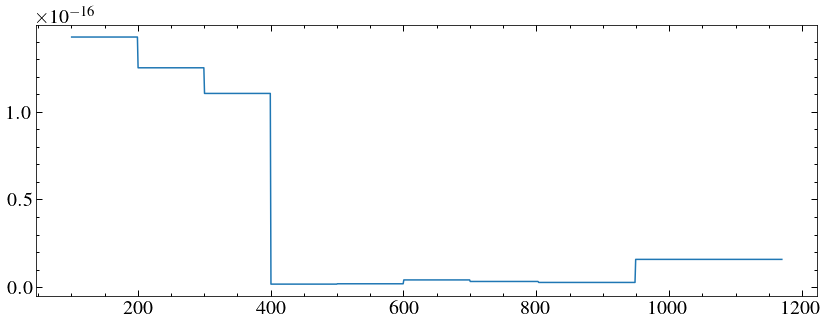

In [57]:
def euv_estimator(euv_inputs):
    
    lya, distance = euv_inputs['lya'], euv_inputs['distance']
        
    distance_conversion = ((1*u.au.to(u.m))/(distance*u.pc.to(u.m)))**2

    lya_1au = lya / distance_conversion

    w1 = np.array([100,200,300,400,500,600,700,800,912], dtype=float) #A
    w2 = np.array([200,300,400,500,600,700,800,912,1170], dtype=float)
    bandwidth = w2-w1

    a = np.array([-0.491,-0.548,-0.602,-2.294,-2.098,-1.920,-1.894,-1.811,-1.004], dtype=float)
    b = np.array([ 0.,    0.,    0.,    0.258, 0.572, 0.240, 0.518, 0.764, 0.065], dtype=float)

    #log(f/lya) = a + b *log(lya)
    f = a + b*np.log10(lya_1au)
    

   # print('Total EUV=',np.sum(f))
    f = (lya_1au * 10**f)/bandwidth

    f *= distance_conversion

    #extrapolate onto 1A grid
    wavelength = np.arange((w1[0])+0.5, (w2[-1])+0.5, 1.0)
    flux = interp1d(np.mean([w1, w2], axis=0), f, kind='nearest', bounds_error=False, fill_value='extrapolate')(wavelength)
    
    print(len(f))
    print(len(np.mean([w1, w2], axis=0)))
    
    print(flux[0], flux[-1])
    print(wavelength[0], wavelength[-1])
    plt.plot(wavelength, flux)
    
euv_estimator(euv_inputs)

Extra APEC models in pyxspec?

In [2]:
from  xspec import *

In [3]:
# m1 = Model("phabs*po + ga")

In [4]:
m1 = Model('apec*phabs')

Reading APEC data from 3.0.9


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________



In [5]:
Plot.xAxis = "angstrom"
Plot.perHz = False

In [6]:
Plot("model")

In [7]:
xVals = Plot.x()
yVals = Plot.model()

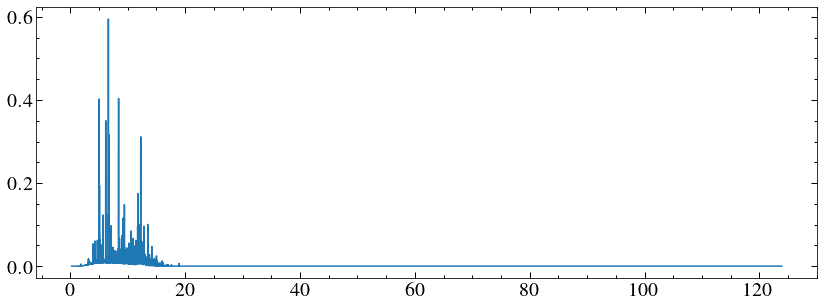

In [8]:
plt.plot(xVals, yVals)

In [9]:
AllModels.setEnergies(".3 10. 100")


Models will now use energy array created from:
   0.3 - 10   100 linear bins



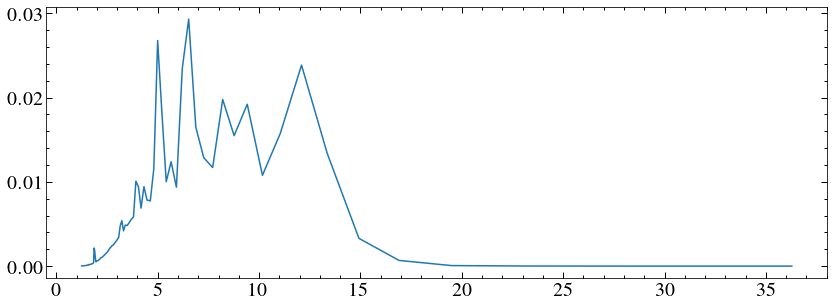

In [10]:
# m1 = Model('apec*phabs')
Plot("model")
xVals = Plot.x()
yVals = Plot.model()
plt.plot(xVals, yVals)

In [11]:
m1.setPars({1:1.0})

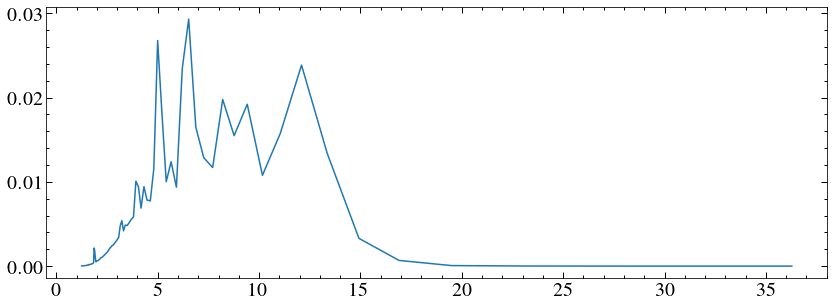

In [12]:
Plot("model")
xVals = Plot.x()
yVals = Plot.model()
plt.plot(xVals, yVals)

In [56]:
stars = ['gj15a', 'gj163', 'gj699', 'gj849', 'lhs-2686']
lx = [8.5, 1.97, 6.3, 4.74, 15.3]
kt = [0.45, 0.51, 0.54, 0.32, 0.90]
abd = [0.195, 0.195, 0.19, 0.195, 0.61]
nh = [1., 1., 0.5, 1.0, 1.0]

gj15a

Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      0.450000     +/-  0.0          
   2    1   apec       Abundanc            0.195000     frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000E-03  +/-  0.0       

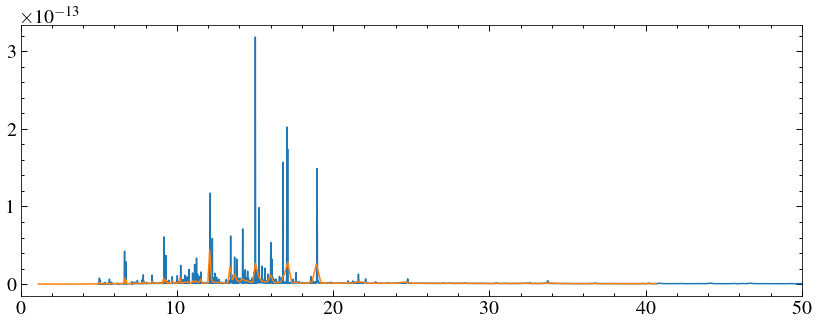

gj163

Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      0.510000     +/-  0.0          
   2    1   apec       Abundanc            0.195000     frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000E-03  +/-  0.0       

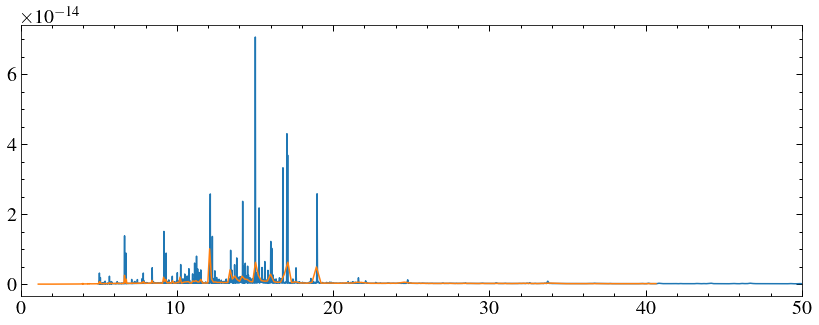

gj699

Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      0.540000     +/-  0.0          
   2    1   apec       Abundanc            0.190000     frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    5.00000E-04  +/-  0.0       

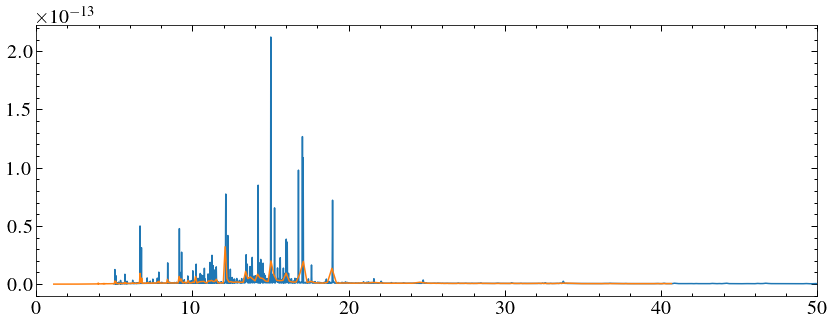

gj849

Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      0.320000     +/-  0.0          
   2    1   apec       Abundanc            0.195000     frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000E-03  +/-  0.0       

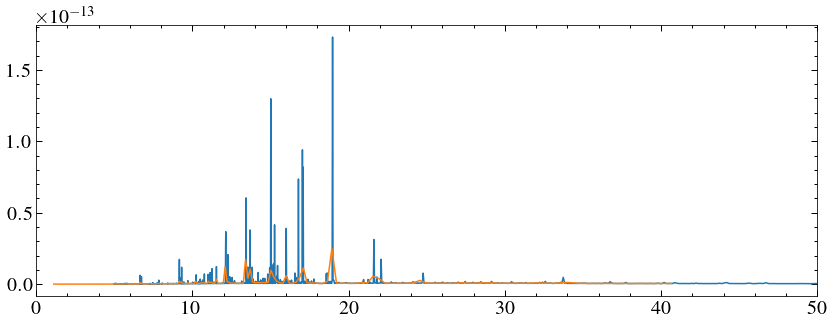

lhs-2686

Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000      +/-  0.0          
________________________________________________________________________


Model apec<1>*phabs<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      0.900000     +/-  0.0          
   2    1   apec       Abundanc            0.610000     frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
   5    2   phabs      nH         10^22    1.00000E-03  +/-  0.0    

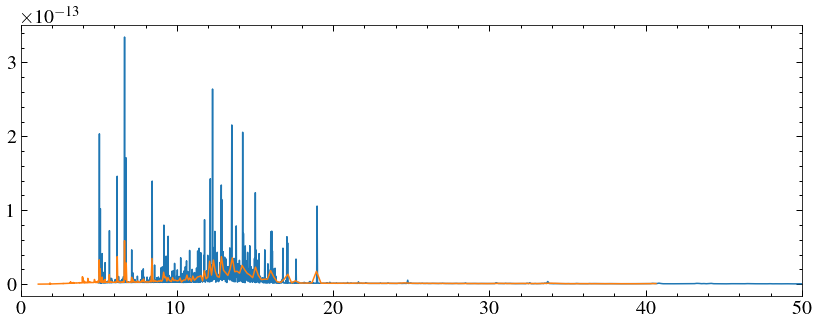

In [58]:
for i, star in enumerate(stars):
    print(star)
    mod = Model('apec*phabs', setPars={1:kt[i], 2:abd[i], 5:nh[i]*1e-3})
    AllModels.setEnergies(".3 10. 1000")
    flux = AllModels.calcFlux(".3 10")
    # print(flux)
    # print('flux=', mod.flux[0])
    fluxnum = mod.flux[0]
    norm = lx[i]*1e-14/fluxnum
    # print(norm)
    # Plot("model")
    # xVals = Plot.x()
    # yVals = Plot.model()
    # plt.plot(xVals, yVals)
    mod.setPars({4:norm})
    AllModels.setEnergies("0.1 2.5 2400")
    Plot("model")
    xVals = Plot.x()
    yVals = Plot.model()
    wx = xVals*u.AA
    fx  = (yVals * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
    plt.plot(wx, fx)
    comp_mod = Table.read('/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/{}/components_v1/hlsp_muscles_model_apec_{}_na_v1_component-spec.ecsv'.format(star.upper(), star)) #check it looks the same as Alex's
    plt.plot(comp_mod['WAVELENGTH'], comp_mod['FLUX'])
    plt.xlim(0, 50)
    # flux = AllModels.calcFlux(".3 10")
    # print(flux)
    plt.show()
    savdat = Table([wx, fx], names=['WAVELENGTH', 'FLUX'])
    ascii.write(savdat, 'fake_apecs/{}apec.txt'.format(star), format='basic', overwrite=True)    

In [59]:
import prepare_model

In [67]:
for star in stars:
    hlsp_path = '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/{}/components_v1/'.format(star.upper())
    if star == 'gj15a':
        sed_table = Table.read('{}hlsp_muscles_hst_stis_{}_e140m_v2_component-spec.ecsv'.format(hlsp_path, star))
    else:
        sed_table = Table.read('{}hlsp_muscles_hst_cos_{}_g130m_v1_component-spec.ecsv'.format(hlsp_path, star))
    
    prepare_model.make_model_spectrum('fake_apecs/{}apec.txt'.format(star), 1, sed_table ,savepath = hlsp_path, save_ecsv=True, save_fits=True, model_name='apec')

/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ15A/components_v1/
Spectrum saved as hlsp_muscles_model_apec_gj15a_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_apec_gj15a_na_v1_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ163/components_v1/
Spectrum saved as hlsp_muscles_model_apec_gj163_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_apec_gj163_na_v1_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ699/components_v1/
Spectrum saved as hlsp_muscles_model_apec_gj699_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_apec_gj699_na_v1_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ849/components_v1/
Spectrum saved as hlsp_muscles_model_apec_gj849_na_v1_component-spec.ecsv
Spectrum saved as hlsp_muscles_model_apec_gj849_na_v1_component-spec.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/LHS-2686/components_v1/
Spectrum saved as hlsp_muscles_model_apec_lhs-2686_na_v

Check if the EUVs are broken. Nans at the ends of some of them. TRAPPIST-1 doesn't have one

In [77]:
euvs = glob.glob('/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/*/components_v1/*euv-scaling*fits')
euvs

['/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ1132/components_v1/hlsp_muscles_model_euv-scaling_gj1132_na_v1_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ15A/components_v1/hlsp_muscles_model_euv-scaling_gj15a_na_v1_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ163/components_v1/hlsp_muscles_model_euv-scaling_gj163_na_v1_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ649/components_v1/hlsp_muscles_model_euv-scaling_gj649_na_v1_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ674/components_v1/hlsp_muscles_model_euv-scaling_gj674_na_v1_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ676A/components_v1/hlsp_muscles_model_euv-scaling_gj676a_na_v1_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ699/components_v1/hlsp_muscles_model_euv-scaling_gj699_na_v1_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscle

/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ1132/components_v1/hlsp_muscles_model_euv-scaling_gj1132_na_v1_component-spec.fits
5.649864712997113e-17 5.815182325295145e-18
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ15A/components_v1/hlsp_muscles_model_euv-scaling_gj15a_na_v1_component-spec.fits
1.0880025190171582e-14 1.3455562175185223e-15
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ163/components_v1/hlsp_muscles_model_euv-scaling_gj163_na_v1_component-spec.fits
4.61674659404907e-16 5.605899004986962e-17
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ649/components_v1/hlsp_muscles_model_euv-scaling_gj649_na_v1_component-spec.fits
3.8741929460551624e-15 5.148317100244236e-16
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ674/components_v1/hlsp_muscles_model_euv-scaling_gj674_na_v1_component-spec.fits
7.26411177385343e-15 9.031365890577797e-16
/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/GJ676A/components_v1/hlsp_muscles_model_euv-scaling_gj676a_na_v1_com

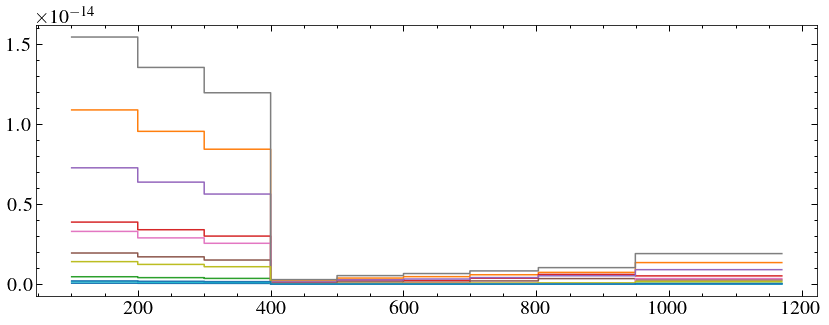

In [78]:
for euv in euvs:
    print(euv)
    # data = Table.read(euv)
    data = fits.getdata(euv, 1)
    plt.step(data['WAVELENGTH'], data['FLUX'], where='mid')
    print(data['FLUX'][0], data['FLUX'][-1])

Looks fine?